In [1]:
#pip install python-craigslist

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Dependencies
from craigslist import CraigslistHousing
import timeit
from tqdm import tqdm
import pickle
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import time
import pandas as pd
import missingno
import re

from urls_list import * #where all urls and paths are saved

# Extract

###  Craigslist api call to extract the listing url and basic information

In [2]:
##Initially we scrape all 3000 in entire toronto. Then, we scrape on a daily posting basis from craiglist while building app
#https://toronto.craigslist.org/search/apa?bundleDuplicates=1&availabilityMode=0&sale_date=all+dates

In [3]:
def craigs_list_api_call():
    
    cl_tor_housing = CraigslistHousing(site='toronto',
                             filters={'bundle_duplicates': 1})

    #If geotagged=True, the results will include the (lat, lng) in the 'geotag' attrib (this will make the process a little bit longer).
    craiglist_housing = []

    start = timeit.timeit()
    for result in tqdm(cl_tor_housing.get_results(sort_by='newest', geotagged=True)):
        craiglist_housing.append(result)
    end = timeit.timeit()
    print(f"Time elapsed is {end - start}")
    return craiglist_housing

#craiglist_housing = craigs_list_api_call()

In [4]:
#with open('craiglist_housing.pkl', 'wb') as f:
    #pickle.dump(craiglist_housing, f)

with open('craiglist_housing.pkl', 'rb') as f:
    craiglist_housing = pickle.load(f)

###  Scraping the craigslist posting data using the urls obtained through API call

In [5]:
def instatiate_driver():
    #########################################################################################
    #Instatiate Selenium driver
    #Returns the handle object
    #########################################################################################
    chrome_options = webdriver.ChromeOptions()
    CHROMEDRIVER_PATH = executable_path
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(executable_path=CHROMEDRIVER_PATH, options=chrome_options)
    return driver

In [6]:
def craigs_list_scrape(craigs_list_post_docs):
    #Instatiate the selenium driver
    driver = instatiate_driver()
    error_list = []
    

    craigs_list_post_docs_cp = craigs_list_post_docs.copy()
    for post in tqdm(craigs_list_post_docs_cp):

        #Visit the url
        driver.get(post['url'])

        #Separate Try Except to handle each cases separately
        #Apartment feature(Some extra feature beside the title)
        try:
            apartment_feature = driver.find_element_by_css_selector('span[class="postingtitletext"] span[class="housing"]').text
        except:
            #print(post['id'])
            error_list.append({post['id']:'apartment_feature'})
            apartment_feature = None
        finally:
            post['apartment_feature'] = apartment_feature

        #First image if present   
        try:
            image = None
            if post['has_image']:
                image = driver.find_element_by_css_selector('div[class="gallery"]').find_element_by_css_selector('img').get_attribute('src')
        except:
            print(post['id'])
            error_list.append({post['id']:'image'})
        finally:
            post['has_image'] = image

        #Body of the post  
        try:
            posting = driver.find_element_by_id("postingbody").text
        except:
            print(post['id'])
            error_list.append({post['id']:'postingbody'})
            posting = None
        finally:
            post['posting'] = posting

        #Attributes      
        try:
            attributes = [elem.text for elem in driver.find_elements_by_css_selector('p[class="attrgroup"]  span')]
        except:
            print(post['id'])
            error_list.append({post['id']:'attributes'})
            attributes = []
        finally:
            post['attributes'] = attributes
            
        time.sleep(1)
            
    driver.quit()       
    return craigs_list_post_docs_cp
    

In [7]:
#craiglist_housing_enriched = craigs_list_scrape(craiglist_housing)

In [8]:
#with open('craiglist_housing_enriched.pkl', 'wb') as f:
    #pickle.dump(craiglist_housing_enriched, f)

with open('craiglist_housing_enriched.pkl', 'rb') as f:
    craiglist_renting_data = pickle.load(f)

# Transform

### Initial form of data after scraping

In [383]:
DF = pd.DataFrame(craiglist_renting_data)
DF.head()

,id,repost_of,name,url,datetime,last_updated,price,where,has_image,geotag,deleted,apartment_feature,posting,attributes
0,7175656775,None,2 Bedrooms Apartment for Rent - 1350 Danforth ...,https://toronto.craigslist.org/tor/apa/d/scarb...,2020-08-11 17:00,2020-08-11 17:00,"$1,350",1350 Danforth Road,https://images.craigslist.org/00F0F_l6VTmsBVGh...,"(43.7464, -79.2323)",False,/ 2br -,Please view our available units by clicking on...,"[2BR / 1Ba, cats are OK - purrr, dogs are OK -..."
1,7175641724,4905301368,☎2 Room+Separate Reception @Etobicoke/Miss☎,https://toronto.craigslist.org/tor/off/d/2-roo...,2020-08-11 16:59,2020-08-11 16:59,"$1,599",Skymark Ave,https://images.craigslist.org/00q0q_hhCvFpP61t...,"(43.663625, -79.593099)",False,None,*SPECIAL OFFER - $200 off the monthly rent for...,[]
2,7175652366,7156890373,87 Peter - Slate - 1bed Sept 1,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:53,2020-08-11 16:53,"$2,000",downtown,https://images.craigslist.org/01212_1tx3p0rlYW...,"(43.646603, -79.392271)",False,/ 1br - 538ft2 -,87 Peter St –#3311 Slate – 1bed/1bath - 538 Sq...,"[1BR / 1Ba, 538ft2, available sep 1, cats are ..."
3,7175652126,7156846968,Harbour Plaza! 1Bed/1Bath +media area - September,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:52,2020-08-11 16:52,"$2,250",Waterfront,https://images.craigslist.org/00Q0Q_huAI9VgN8a...,"(43.641093, -79.380324)",False,/ 1br - 595ft2 -,$2250 - 88 Harbour #2405 – 1Bed/1Bath (media a...,"[1BR / 1Ba, 595ft2, available sep 1, condo, w/..."
4,7175651860,6808310702,The Eglinton / Redpath -studio,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:52,2020-08-11 16:52,"$1,750",125 Redpath Ave,https://images.craigslist.org/00J0J_3SYJ5EqHxl...,"(43.707766, -79.392611)",False,/ 1br - 359ft2 -,The Eglinton- Maxwell #2711 -359 SqFt Studio $...,"[1BR / 2Ba, 359ft2, available aug 14, condo, w..."


### Remove Duplicates and unreliable data
- All duplicated data are removed
- Dont consider empty postings
- Drop all those rows which don't have both 'geotag' and 'where'

In [384]:
## Check for duplicates in the dataset

In [385]:
duplicates = DF[DF.duplicated(DF.columns[:-1], keep=False)] #Duplicates cannot hash list
DF.drop_duplicates(subset=DF.columns[:-1], keep="first", inplace=True)
#Now id is unique
DF[DF.duplicated(DF.columns[0], keep=False)]


,id,repost_of,name,url,datetime,last_updated,price,where,has_image,geotag,deleted,apartment_feature,posting,attributes


(21, 14)

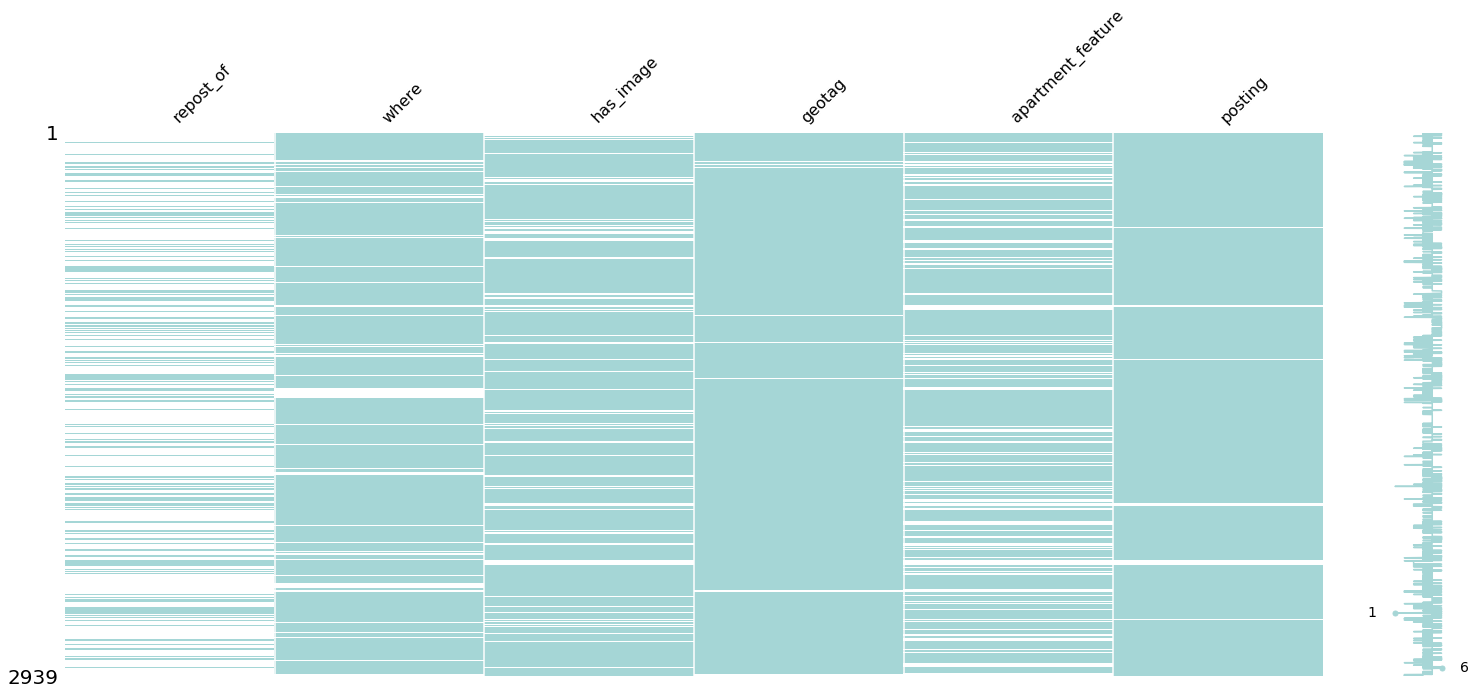

In [386]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.65,0.84,0.84))
#Dont consider empty postings
DF.dropna(subset=['posting'], inplace=True)

#Location:- Coming to whereabouts, in most of the cases, we have geotag. Some of the cases which doesn't have geotag,
#we have "where". Check below.
DF[DF[['geotag', 'where']].apply(lambda x: (x['where'] is not None) and  (x['geotag'] is None) , axis=1)].shape
#We need to drop all those rows which don't have both
DF.dropna(subset=['where', 'geotag'], how='all', inplace=True)

## Deive new Features
- Combine the "attributes", "apartment_feature", "posting" together as "text" column for string search using regex to derive new features
- New features derived are
    - sf - Square Feet : (int or None) Based on ft2|SqFt in the text data
    - br - Bed Room: (float or None) Number of bedrooms, based on what is preceding BR 
    - ba - Bath: (float or None) Number of bath, based on what is preceding Ba
    - cats_allowed - True or False, based on the presence of 'cats are OK - purrr'
    - dogs are OK - wooof - True or False, based on the presence of 'dogs are OK - wooof'
    - Type - Type of the housing 1 out of ``['condo', 'house', 'apartment', 'suite', 'townhouse', 'loft', 'duplex',
       'flat', 'cottage', 'land']`` or ``None``
    - furnished - True/Flase/None - based on the presense of (un|non)(-) furnished strings or nothing
    

```unique_attributes = set()
for entry in DF['attributes']:
    unique_attributes = unique_attributes.union(set(entry))
unique_attributes```  

In [387]:
#Convert list to string
DF['attributes'] = DF['attributes'].map(lambda x: ' '.join(x))
#Convert the apartment feature none to ''(string)
DF['apartment_feature'].fillna(value=' ', inplace=True)#A string val
#Combine the "attributes", "apartment_feature", "posting" together as "text" column
DF["text"] = DF.apply(lambda x: x["attributes"]+x["apartment_feature"]+x["posting"], axis=1)
#Use DF["text"] for all further extractions 



In [388]:
def extract(s):
    #DF['Text'] comes here as the input
    #Square Feet
    sf_found = re.findall('(\d+) *(ft2|SqFt)', s)
    sf =  (None if not sf_found else int(sf_found[0][0]))

    #Bed Room
    br_found = re.findall('(\d){0,1}(.5){0,1} *BR', s)
    br =  (None if not br_found  else float(''.join(br_found[0])))
    
    #Bath
    ba_found = re.findall('(\d){0,1}(.5){0,1}(\+){0,1} *B[aA]',s)
    ba =  (None if not ba_found  else float(''.join(ba_found[0])))
    
    #'cats are OK - purrr'
    cats_allowed = (True if re.findall('cats are OK - purrr', s) else False)
    
    #'dogs are OK - wooof'
    dogs_allowed = (True if re.findall('dogs are OK - wooof', s) else False)
    
    #Check the type of the commodity
    re.sub(r'[\n\.,!/?()]', ' ', DF['text'].iloc[0].lower()) #Remove unnecessary chars. We need to capture apartment\ also as word apartment
    cleaned_s = re.sub('[\n\\.,!\/?]', ' ', s)
    found_type = re.findall(r"\b(townhouse|loft|land|house|flat|duplex|condo|cottage|suite)\b", cleaned_s, flags=re.IGNORECASE) 
    Type = (None if not found_type else found_type[0].lower())
    #Though apartment is a generic term, some people mention the type as apartment, we are going to take that as the last priority
    #if nothing else is mentioned
    if not Type:
        found_type = re.findall(r"\bapartment\b", cleaned_s, flags=re.IGNORECASE)
        Type = (None if not found_type else found_type[0].lower())
        
    #Furnished or Unfurnished checks
    found_un = re.findall('(non|un)-*(?=furnished)', s , flags=re.IGNORECASE)
    furnished = False
    if not found_un:
        #furnished = None #Nothing found
        found_furnished = re.findall('furnished', s , flags=re.IGNORECASE)
        furnished = (None if not found_furnished else True)
    
    return [sf,br,ba, cats_allowed, dogs_allowed, Type, furnished]

In [389]:
DF[['sf', 'BR', 'Ba','cats_allowed', 'dogs_allowed', 'Type', 'furnished']] = pd.DataFrame(DF['text'].map(lambda x : extract(x)).to_list(), index=DF.index)

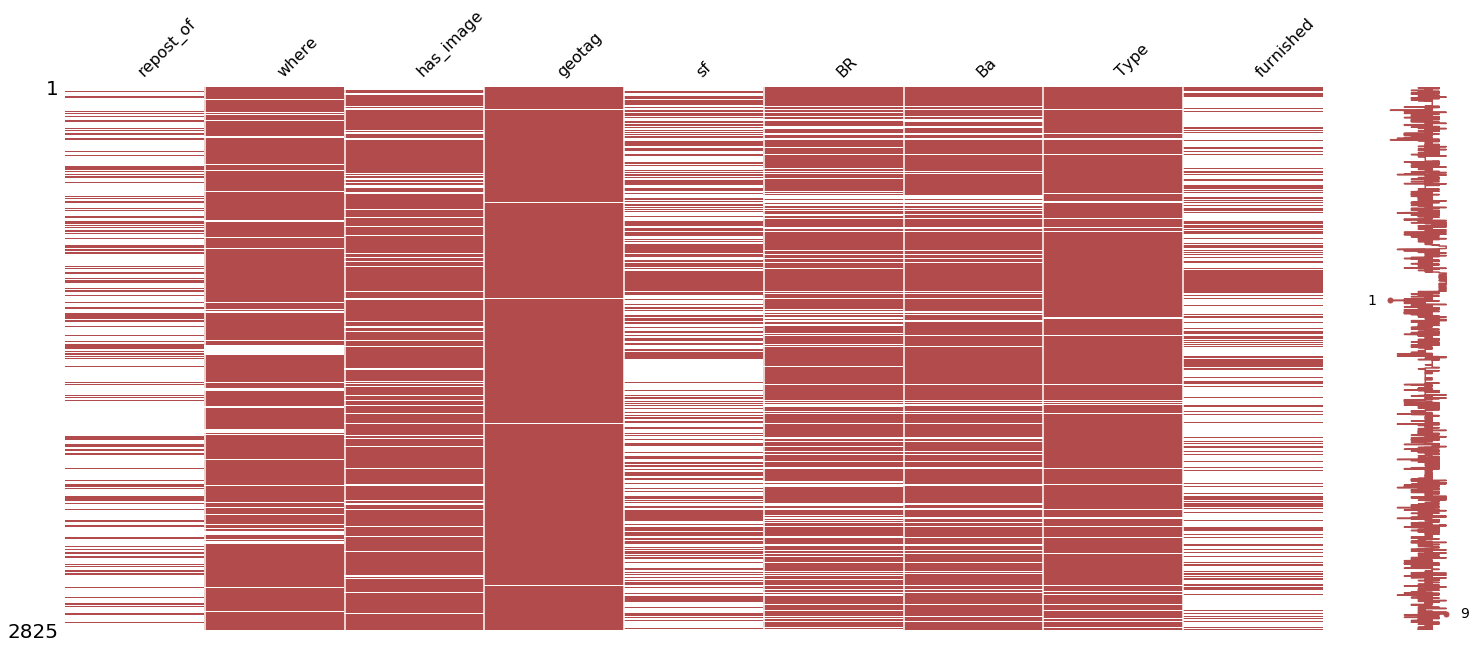

In [390]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.7,0.3,0.3))
